# Étape 2 — Analyse de Données (SQL)

Ce notebook lit vos données depuis MySQL (base `dataControl`) et génère :
- Distribution des classes (fake / hate / normal)
- Nuages de mots (WordCloud)
- Statistiques lexicales (longueur moyenne, top mots)
- Détection de mots sensibles récurrents

Prérequis : tables `news` et `labeled` créées par l'Étape 1.
Si la connexion à MySQL échoue, un *fallback* chargera `data/*.csv`.


In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sqlalchemy import create_engine
from collections import Counter
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set(style='whitegrid')
except Exception:
    sns = None

try:
    from wordcloud import WordCloud, STOPWORDS
except Exception:
    WordCloud = None
    STOPWORDS = set()


In [9]:
# Configuration MySQL
DB_USERNAME = 'root'
DB_PASSWORD = ''
DB_HOST = 'localhost'
DB_PORT = '3306'
DB_NAME = 'dataControl'

connection_string = f'mysql+pymysql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

print('=' * 70)
print('CONNEXION A LA BASE DE DONNEES')
print('=' * 70)
try:
    engine = create_engine(connection_string)
    with engine.connect() as conn:
        print('✓ Connexion MySQL réussie!')
except Exception as e:
    engine = None
    print(f'✗ Erreur de connexion: {e}')


CONNEXION A LA BASE DE DONNEES
✓ Connexion MySQL réussie!


In [10]:
# Utilitaires et fonctions d'analyse
def safe_text_column(df):
    for col in ['text_processed', 'text_cleaned', 'text', 'tweet']:
        if col in df.columns:
            return col
    raise ValueError('Aucune colonne texte trouvée')

def load_table(table_name: str) -> pd.DataFrame:
    return pd.read_sql(f'SELECT * FROM {table_name}', engine)

def map_news_label_to_class(label: str) -> str:
    label = str(label).strip().lower() if pd.notna(label) else ''
    return 'fake' if label == 'fake' else 'normal'

def map_labeled_class_to_class(cls) -> str:
    try:
        cls_int = int(cls)
    except Exception:
        return 'normal'
    return 'hate' if cls_int in (0, 1) else 'normal'

def plot_class_distribution(df: pd.DataFrame, class_col: str, title: str):
    counts = df[class_col].value_counts().sort_index()
    print(f'\n📊 Distribution des classes - {title}')
    print(counts)
    plt.figure(figsize=(6, 4))
    if sns is not None:
        sns.barplot(x=counts.index, y=counts.values, palette='deep')
    else:
        plt.bar(counts.index, counts.values, color='#4C78A8')
    plt.title(title)
    plt.xlabel('Classe')
    plt.ylabel('Nombre')
    plt.tight_layout()
    plt.show()

def generate_wordcloud(texts, title: str, max_words: int = 200):
    if WordCloud is None:
        print("⚠️ 'wordcloud' non installé. Exécutez: pip install wordcloud")
        return
    combined_text = ' '.join(texts)
    wc = WordCloud(width=900, height=500, background_color='white', stopwords=STOPWORDS, max_words=max_words).generate(combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def lexical_stats(df: pd.DataFrame, text_col: str, title: str, top_n: int = 20):
    lengths = df[text_col].astype(str).str.split().apply(len)
    avg_len = lengths.mean()
    print(f'\n🧮 Statistiques lexicales ({title}):')
    print(f'- Longueur moyenne (mots): {avg_len:.2f}')
    stop = set(STOPWORDS) | {'rt', 'amp', 'https', 'http', 'co'}
    words = (word for text in df[text_col].astype(str) for word in text.split())
    filtered = [w for w in words if len(w) > 2 and w.lower() not in stop]
    freq = Counter(filtered).most_common(top_n)
    print('- Top mots-clés:')
    for w, c in freq:
        print(f'  {w}: {c}')
    if freq:
        labels, values = zip(*freq)
        plt.figure(figsize=(10, 4))
        if sns is not None:
            sns.barplot(x=list(labels), y=list(values), palette='muted')
        else:
            plt.bar(labels, values, color='#F58518')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Top {top_n} mots-clés - {title}')
        plt.xlabel('Mot')
        plt.ylabel('Fréquence')
        plt.tight_layout()
        plt.show()

SENSITIVE_KEYWORDS = {
    'haine', 'insulte', 'injure', 'mensonge', 'menteur', 'raciste', 'violence',
    'hate', 'insult', 'lie', 'liar', 'racist', 'violence', 'kill', 'bitch', 'fuck'
}

def detect_sensitive_words(df: pd.DataFrame, text_col: str, title: str, keywords=SENSITIVE_KEYWORDS):
    print(f'\n🚨 Mots sensibles ({title})')
    counts = {k: 0 for k in keywords}
    for text in df[text_col].astype(str):
        tokens = text.split()
        for k in keywords:
            counts[k] += sum(1 for t in tokens if t.lower() == k)
    sorted_counts = sorted(((k, v) for k, v in counts.items() if v > 0), key=lambda x: x[1], reverse=True)
    if not sorted_counts:
        print('- Aucun mot sensible détecté dans cet échantillon.')
        return
    for k, v in sorted_counts:
        print(f'  {k}: {v}')
    labels, values = zip(*sorted_counts)
    plt.figure(figsize=(8, 4))
    if sns is not None:
        sns.barplot(x=list(labels), y=list(values), palette='dark')
    else:
        plt.bar(labels, values, color='#54A24B')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Mots sensibles - {title}')
    plt.xlabel('Mot')
    plt.ylabel('Occurrences')
    plt.tight_layout()
    plt.show()


ETAPE 2 : ANALYSE DE DONNEES

📊 Distribution des classes - NEWS (fake/normal)
class_norm
fake      10056
normal     9944
Name: count, dtype: int64


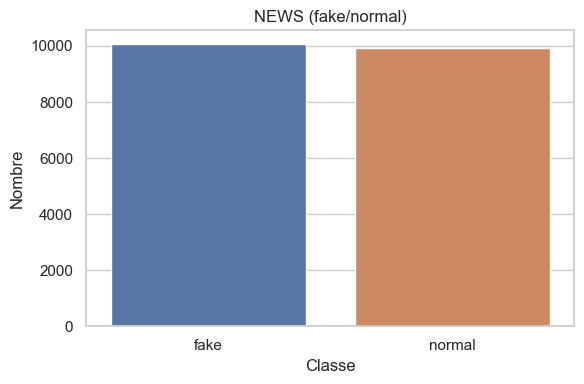


📊 Distribution des classes - LABELED (hate/normal)
class_norm
hate      20606
normal     4154
Name: count, dtype: int64


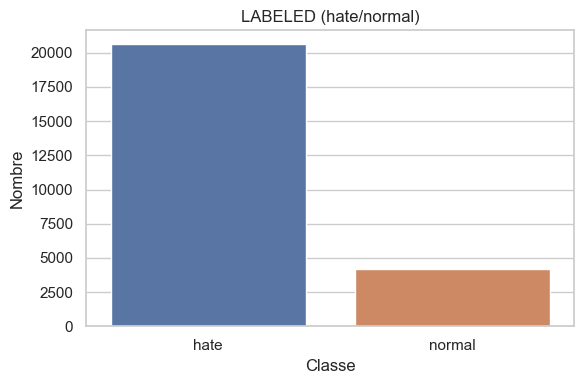

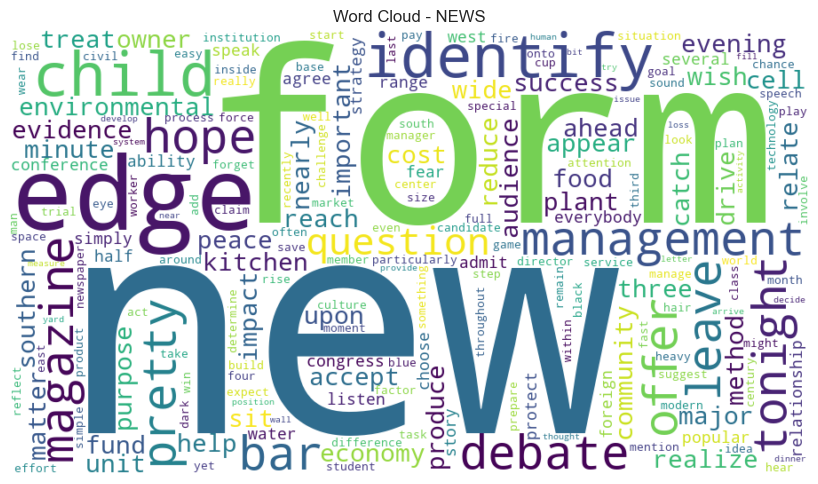

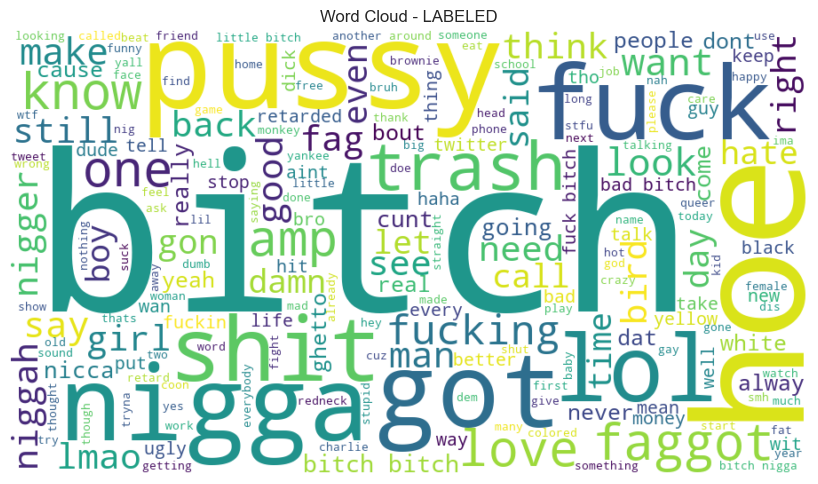


🧮 Statistiques lexicales (NEWS):
- Longueur moyenne (mots): 222.15
- Top mots-clés:
  listen: 5341
  purpose: 5339
  wear: 5338
  summer: 5323
  thought: 5320
  child: 5314
  direction: 5312
  factor: 5311
  ability: 5311
  wide: 5308
  relate: 5306
  size: 5305
  member: 5305
  produce: 5304
  lose: 5304
  bar: 5295
  leave: 5295
  look: 5290
  act: 5287
  near: 5287


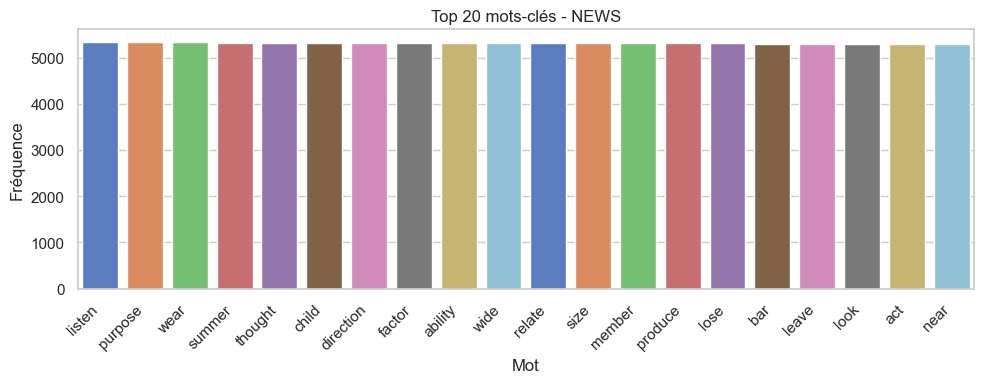


🧮 Statistiques lexicales (LABELED):
- Longueur moyenne (mots): 6.82
- Top mots-clés:
  bitch: 11437
  hoe: 4341
  pussy: 2250
  nigga: 2016
  got: 1602
  fuck: 1461
  shit: 1298
  trash: 1160
  lol: 1101
  know: 860
  one: 762
  love: 739
  girl: 699
  want: 661
  fucking: 630
  bird: 602
  make: 601
  look: 588
  say: 578
  bad: 572


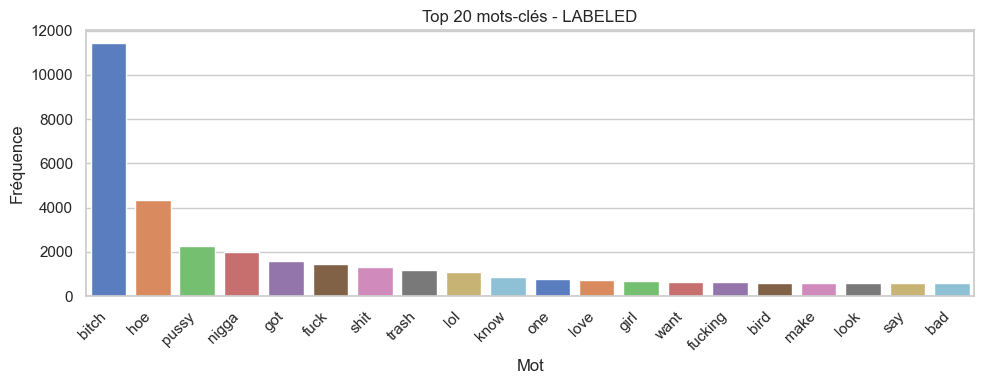


🚨 Mots sensibles (NEWS)
- Aucun mot sensible détecté dans cet échantillon.

🚨 Mots sensibles (LABELED)
  bitch: 11437
  fuck: 1461
  hate: 486
  kill: 143
  lie: 84
  racist: 70
  insult: 11
  liar: 8
  violence: 4


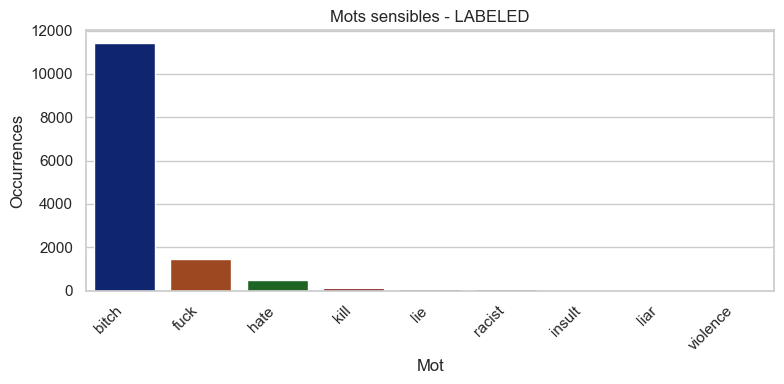


📊 Distribution des classes - COMBINÉ (fake/hate/normal)
class_norm
fake      10056
hate      20606
normal    14098
Name: count, dtype: int64


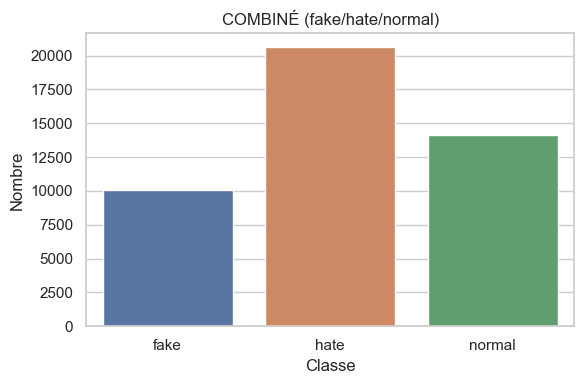


🧮 Statistiques lexicales (COMBINÉ):
- Longueur moyenne (mots): 103.04
- Top mots-clés:
  bitch: 11437
  know: 6022
  one: 5903
  look: 5878
  girl: 5844
  want: 5804
  say: 5768
  man: 5750
  make: 5738
  need: 5721
  think: 5697
  time: 5683
  bad: 5670
  see: 5660
  real: 5650
  really: 5639
  good: 5621
  day: 5609
  never: 5588
  people: 5587


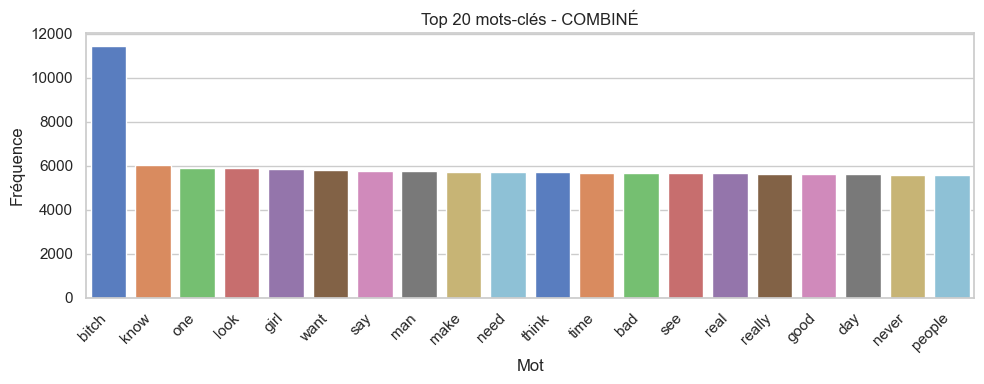

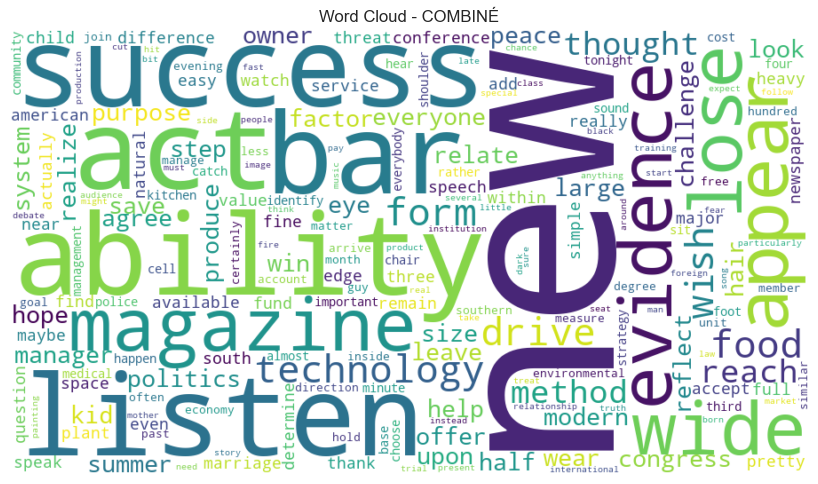


🚨 Mots sensibles (COMBINÉ)
  bitch: 11437
  fuck: 1461
  hate: 486
  kill: 143
  lie: 84
  racist: 70
  insult: 11
  liar: 8
  violence: 4


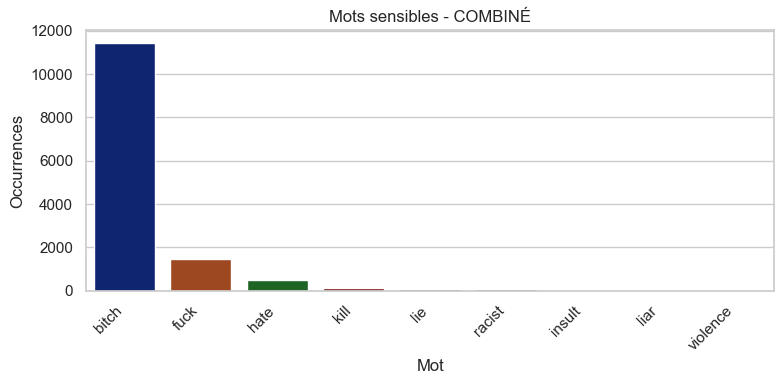


✅ Étape 2 complétée.


In [11]:
# Chargement des données et exécution de l'analyse
print('=' * 70)
print('ETAPE 2 : ANALYSE DE DONNEES')
print('=' * 70)

if engine is None:
    print('⚠️ Fallback CSV: chargement depuis data/*.csv')
    df_news = pd.read_csv('data/fake_news_dataset.csv')
    df_labeled = pd.read_csv('data/labeled_data.csv')
else:
    df_news = load_table('news')
    df_labeled = load_table('labeled')

text_news = safe_text_column(df_news)
text_labeled = safe_text_column(df_labeled)

# Classes normalisées
df_news['class_norm'] = df_news['label'].apply(map_news_label_to_class) if 'label' in df_news.columns else 'normal'
df_labeled['class_norm'] = df_labeled['class'].apply(map_labeled_class_to_class) if 'class' in df_labeled.columns else 'normal'

# Distributions
plot_class_distribution(df_news, 'class_norm', 'NEWS (fake/normal)')
plot_class_distribution(df_labeled, 'class_norm', 'LABELED (hate/normal)')

# Word clouds (échantillons pour performance)
sample_news = df_news[text_news].dropna().astype(str).head(10000)
sample_labeled = df_labeled[text_labeled].dropna().astype(str).head(10000)
generate_wordcloud(sample_news, 'Word Cloud - NEWS')
generate_wordcloud(sample_labeled, 'Word Cloud - LABELED')

# Statistiques lexicales
lexical_stats(df_news, text_news, 'NEWS')
lexical_stats(df_labeled, text_labeled, 'LABELED')

# Mots sensibles
detect_sensitive_words(df_news, text_news, 'NEWS')
detect_sensitive_words(df_labeled, text_labeled, 'LABELED')

# Vue combinée
combined = pd.DataFrame({
    'text': pd.concat([df_news[text_news], df_labeled[text_labeled]], ignore_index=True),
    'class_norm': pd.concat([df_news['class_norm'], df_labeled['class_norm']], ignore_index=True)
})
plot_class_distribution(combined, 'class_norm', 'COMBINÉ (fake/hate/normal)')
lexical_stats(combined, 'text', 'COMBINÉ')
generate_wordcloud(combined['text'].dropna().astype(str).head(15000), 'Word Cloud - COMBINÉ')
detect_sensitive_words(combined, 'text', 'COMBINÉ')

print('\n✅ Étape 2 complétée.')


---
## Conseils
- Si vous voyez un message indiquant que `wordcloud` ou `seaborn` n'est pas installé, exécutez :
  - `pip install wordcloud seaborn`
- Assurez-vous d'utiliser le *kernel* Python de votre environnement virtuel (`venv`).
- Pour des performances rapides, réduisez les échantillons (`head(10000)`).
